In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

In [ ]:
df_price = pd.read_csv("/content/Potato price.csv", encoding='ISO-8859-1')       # Price dataset
df_weather = pd.read_csv("/content/export.csv", encoding='ISO-8859-1')           # Weather dataset
df_occ = pd.read_csv("/content/occasions(Sheet1).csv", encoding='ISO-8859-1')

In [ ]:
# Clean Column Name
def clean_columns(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df

df_price = clean_columns(df_price)
df_weather = clean_columns(df_weather)
df_occ = clean_columns(df_occ)

# Identify the first row that contains actual data in df_price
# The problematic column for price is 'unnamed:_8'
# Find the first index where 'unnamed:_8' can be converted to a number
first_data_row_index = -1
for idx, val in df_price['unnamed:_8'].items():
    try:
        pd.to_numeric(val)
        first_data_row_index = idx
        break
    except (ValueError, TypeError):
        continue

if first_data_row_index != -1:
    df_price = df_price.iloc[first_data_row_index:].copy()
    df_price.reset_index(drop=True, inplace=True)
else:
    print("Warning: No numeric data found in 'unnamed:_8' column for df_price.")

# Inspect
print("Price columns:", df_price.columns)
print("Weather columns:", df_weather.columns)
print("Occasion columns:", df_occ.columns)

Price columns: Index(['min,max,modal_price_from_tamil_nadu,madurai[potato]_from_01-jan-2023to31-dec-2024_(total-664)_(total-664)',
       'unnamed:_1', 'unnamed:_2', 'unnamed:_3', 'unnamed:_4', 'unnamed:_5',
       'unnamed:_6', 'unnamed:_7', 'unnamed:_8', 'unnamed:_9', 'price_date',
       'market'],
      dtype='object')
Weather columns: Index(['ï»¿date', 'tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres', 'date'], dtype='object')
Occasion columns: Index(['occasion_/_festival', 'typical_date_/_month_(approx)', 'type',
       'likely_commodity_impact', 'impact_rating'],
      dtype='object')


In [ ]:
# Price dataset
df_price['price_date'] = pd.to_datetime(df_price['unnamed:_9'], errors='coerce')

# Weather dataset
df_weather['date'] = pd.to_datetime(df_weather['ï»¿date'], errors='coerce')

# Occasion dataset (expand date ranges into daily rows)
def parse_occasion_date(date_str):
    if isinstance(date_str, str):
        date_str = date_str.strip()
        try:
            # Handle date ranges like "18 Jul – 18 Aug" or "24 Dec – 01 Jan"
            if '–' in date_str or 'to' in date_str.lower():
                parts = date_str.replace('–', 'to').split('to')
                start_str = parts[0].strip()
                end_str = parts[-1].strip()
                # Attempt to parse with year, assuming current year if not present
                start_date = pd.to_datetime(start_str + ' 2024', errors='coerce', format='%d %b %Y')
                end_date = pd.to_datetime(end_str + ' 2024', errors='coerce', format='%d %b %Y')
                if pd.isna(start_date) or pd.isna(end_date):
                     # Attempt to parse with just month and day, assuming current year
                    start_date = pd.to_datetime(start_str + ' 2024', errors='coerce', format='%d-%b %Y')
                    end_date = pd.to_datetime(end_str + ' 2024', errors='coerce', format='%d-%b %Y')
                if pd.isna(start_date) or pd.isna(end_date):
                     # Attempt to parse with just month and day, assuming current year
                    start_date = pd.to_datetime(start_str + ' 2024', errors='coerce', format='%d %B %Y')
                    end_date = pd.to_datetime(end_str + ' 2024', errors='coerce', format='%d %B %Y')


                # Handle cases where the range spans across a year end
                if pd.notna(start_date) and pd.notna(end_date) and end_date < start_date:
                    end_date = end_date + pd.DateOffset(years=1)

                return start_date, end_date
            else:
                # Handle single dates or month names
                single_date = pd.to_datetime(date_str + ' 2024', errors='coerce', format='%d-%b %Y')
                if pd.isna(single_date):
                    single_date = pd.to_datetime(date_str + ' 2024', errors='coerce', format='%B %Y')
                if pd.isna(single_date):
                    single_date = pd.to_datetime(date_str + ' 2024', errors='coerce', format='%d %b %Y')
                if pd.isna(single_date):
                    single_date = pd.to_datetime(date_str + ' 2024', errors='coerce', format='%b %Y')

                return single_date, single_date
        except Exception as e:
            print(f"Could not parse date string: {date_str} - {e}")
            return pd.NaT, pd.NaT
    return pd.NaT, pd.NaT

expanded_rows = []
for _, row in df_occ.iterrows():
    start_date, end_date = parse_occasion_date(row['typical_date_/_month_(approx)'])
    if pd.notna(start_date):
        if pd.isna(end_date):
            end_date = start_date # Treat single dates as a range of one day

        for d in pd.date_range(start_date, end_date):
            expanded_rows.append({
                "date": d,
                "occasion": row['occasion_/_festival'],
                "type": row['type'],
                "commodity_impact": row['likely_commodity_impact'],
                "impact_rating": row['impact_rating']
            })

df_occ_expanded = pd.DataFrame(expanded_rows)

/tmp/ipython-input-2560187288.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_price['price_date'] = pd.to_datetime(df_price['unnamed:_9'], errors='coerce')


In [ ]:
# 5. Merge Datasets
# ===============================
# Merge price + weather
df_merged = pd.merge(df_price, df_weather, left_on="price_date", right_on="date", how="left")

# Merge occasions
df_merged = pd.merge(df_merged, df_occ_expanded, left_on="price_date", right_on="date", how="left", suffixes=("", "_occ"))

# Drop duplicate date columns
df_merged = df_merged.drop(columns=["date_occ"], errors="ignore")

In [ ]:
print(df_merged.to_string())

     min,max,modal_price_from_tamil_nadu,madurai[potato]_from_01-jan-2023to31-dec-2024_(total-664)_(total-664)     unnamed:_1                       unnamed:_2 unnamed:_3     unnamed:_4 unnamed:_5               unnamed:_6               unnamed:_7                 unnamed:_8  unnamed:_9 price_date           ï»¿date  tavg  tmin  tmax  prcp  wspd    pres       date occasion type commodity_impact impact_rating
0                                                                                                       Sl no.  District Name                      Market Name  Commodity        Variety      Grade  Min Price (Rs./Quintal)  Max Price (Rs./Quintal)  Modal Price (Rs./Quintal)  Price Date        NaT  13-01-2023 00:00  24.1  17.4  30.8   0.0  11.2  1012.9        NaT      NaN  NaN              NaN           NaN
1                                                                                                       Sl no.  District Name                      Market Name  Commodity        Variety

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using


📊 Model Accuracy Comparison:
                  Model         MAE        RMSE    MAPE (%)        R²
0                 ARIMA  425.851621  593.255152    7.623802 -0.979354
1      XGBoost Residual  425.851621  593.255152  100.000000 -0.977344
2  Hybrid (ARIMA + XGB)  425.851621  593.255152    7.623802 -0.979354


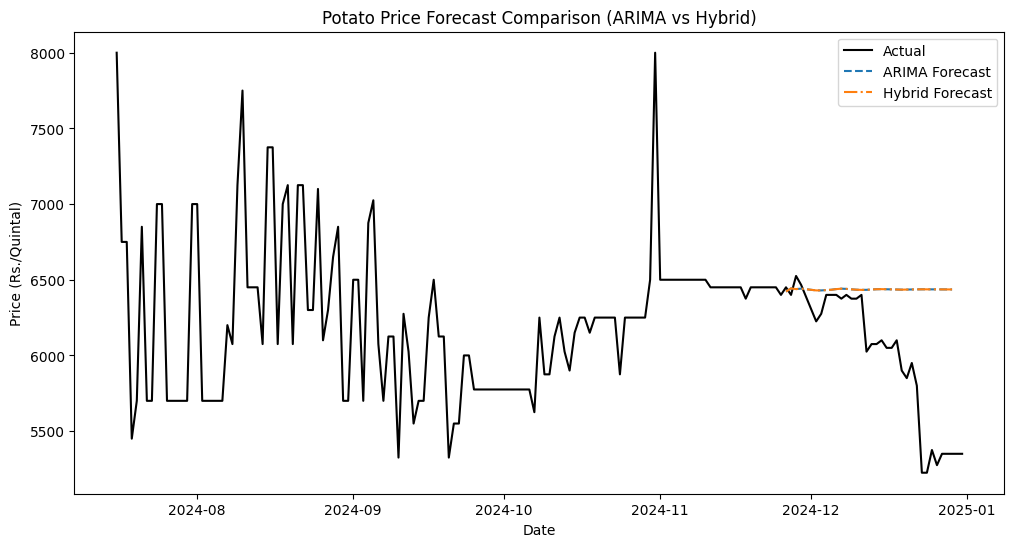

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =========================
# Prepare dataset
# =========================
df = df_price.iloc[1:][['price_date','unnamed:_8']].rename(
    columns={'price_date':'ds','unnamed:_8':'y'}
)

# Convert to numeric
df['y'] = pd.to_numeric(df['y'], errors='coerce')

# Drop rows with missing 'y' (price) or 'ds' (date)
df = df.dropna(subset=['y', 'ds'])

# Handle duplicate dates: aggregate 'y' by taking the mean for each unique 'ds'
df = df.groupby('ds')['y'].mean().reset_index()

df.set_index('ds', inplace=True)

# =========================
# Split into Train/Test (80/20)
# =========================
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# =========================
# 1️⃣ ARIMA Model
# =========================
arima = ARIMA(train['y'], order=(5,1,2))
arima_fit = arima.fit()

# Forecast for test period
arima_forecast = arima_fit.forecast(steps=len(test))
df.loc[test.index, 'arima_pred'] = arima_forecast

# Residuals for ARIMA training data
df.loc[train.index, 'residual'] = train['y'] - arima_fit.fittedvalues

# =========================
# 2️⃣ XGBoost on Residuals (Recursive Forecasting)
# =========================
lags = 7
df_ml = df.copy()

# Drop NaNs from residual column to prepare for XGBoost training data
df_ml = df_ml.dropna(subset=['residual'])

# Create lag features for residuals (only from training data's residuals)
for lag in range(1, lags + 1):
    df_ml[f'lag_{lag}'] = df_ml['residual'].shift(lag)

# Drop rows where lag features are NaN (initial 'lags' rows of df_ml)
df_ml = df_ml.dropna()

# Prepare X and y for XGBoost training
X_xgb_train = df_ml[[f'lag_{i}' for i in range(1, lags+1)]]
y_xgb_train = df_ml['residual']

# Train XGBoost model
xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
xgb.fit(X_xgb_train, y_xgb_train)

# Predict residuals for the test period recursively
xgb_residual_forecast = []
# Get the last 'lags' actual residuals from the end of the training set
# Ensure we have enough residuals if train_size - lags is small
last_known_residuals = df.loc[X_xgb_train.index, 'residual'].tail(lags).tolist()

for _ in range(len(test)): # Predict for each step in the test set
    if len(last_known_residuals) < lags:
        # Not enough history, pad with zeros or mean if needed
        prediction_input = np.array([0] * (lags - len(last_known_residuals)) + last_known_residuals).reshape(1, -1)
    else:
        prediction_input = np.array(last_known_residuals[-lags:]).reshape(1, -1)

    pred_res = xgb.predict(prediction_input)[0]
    xgb_residual_forecast.append(pred_res)
    # Update current_lags for the next prediction (append new prediction, remove oldest)
    last_known_residuals.append(pred_res)
    if len(last_known_residuals) > lags:
        last_known_residuals.pop(0)

# Store these predicted residuals in df, aligning with test.index
df.loc[test.index, 'xgb_residual_pred'] = xgb_residual_forecast

# =========================
# 3️⃣ Hybrid Forecast = ARIMA + Residual Correction
# =========================
df['hybrid_pred'] = df['arima_pred'] + df['xgb_residual_pred']

# =========================
# 4️⃣ Evaluate Model Accuracy
# =========================
def evaluate_model(y_true, y_pred, model_name):
    # Drop NaNs before evaluation, ensuring y_true and y_pred align
    comparison_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}).dropna()
    if comparison_df.empty:
        return {"Model": model_name, "MAE": np.nan, "RMSE": np.nan, "MAPE (%)": np.nan, "R²": np.nan}

    mae = mean_absolute_error(comparison_df['y_true'], comparison_df['y_pred'])
    rmse = np.sqrt(mean_squared_error(comparison_df['y_true'], comparison_df['y_pred']))
    mape = np.mean(np.abs((comparison_df['y_true'] - comparison_df['y_pred']) / comparison_df['y_true'])) * 100
    r2 = r2_score(comparison_df['y_true'], comparison_df['y_pred'])
    return {
        "Model": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape,
        "R²": r2
    }

results_eval = []
results_eval.append(evaluate_model(test['y'], df.loc[test.index, 'arima_pred'], "ARIMA"))

# Actual residuals for XGBoost evaluation for the test set
actual_test_residuals = test['y'] - df.loc[test.index, 'arima_pred']
results_eval.append(evaluate_model(actual_test_residuals, df.loc[test.index, 'xgb_residual_pred'], "XGBoost Residual"))
results_eval.append(evaluate_model(test['y'], df.loc[test.index, 'hybrid_pred'], "Hybrid (ARIMA + XGB)"))

results_df = pd.DataFrame(results_eval)
print("\n📊 Model Accuracy Comparison:")
print(results_df)

# =========================
# 5️⃣ Show Forecast vs Actual
# =========================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df.index, df['y'], label="Actual", color='black')
plt.plot(df.index, df['arima_pred'], label="ARIMA Forecast", linestyle='--')
plt.plot(df.index, df['hybrid_pred'], label="Hybrid Forecast", linestyle='-.')
plt.title("Potato Price Forecast Comparison (ARIMA vs Hybrid)")
plt.xlabel("Date")
plt.ylabel("Price (Rs./Quintal)")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate_model(y_true, y_pred, model_name):
    # Drop NaNs before evaluation, ensuring y_true and y_pred align
    comparison_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}).dropna()
    if comparison_df.empty:
        return {"Model": model_name, "MAE": np.nan, "RMSE": np.nan, "MAPE (%)": np.nan, "R²": np.nan}

    mae = mean_absolute_error(comparison_df['y_true'], comparison_df['y_pred'])
    rmse = np.sqrt(mean_squared_error(comparison_df['y_true'], comparison_df['y_pred']))
    mape = np.mean(np.abs((comparison_df['y_true'] - comparison_df['y_pred']) / comparison_df['y_true'])) * 100
    r2 = r2_score(comparison_df['y_true'], comparison_df['y_pred'])
    return {
        "Model": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape,
        "R²": r2
    }


# Evaluate using the forecasts already populated in the 'df' DataFrame from the previous cell
results_eval = []

# ARIMA evaluation
results_eval.append(evaluate_model(test['y'], df.loc[test.index, 'arima_pred'], "ARIMA"))

# Actual residuals for XGBoost evaluation for the test set
# This aligns with how it's done in the fixed 1t0_8gtk-wNr cell
actual_test_residuals = test['y'] - df.loc[test.index, 'arima_pred']
results_eval.append(evaluate_model(actual_test_residuals, df.loc[test.index, 'xgb_residual_pred'], "XGBoost Residual"))

# Hybrid evaluation
results_eval.append(evaluate_model(test['y'], df.loc[test.index, 'hybrid_pred'], "Hybrid (ARIMA + XGB)"))

results_df = pd.DataFrame(results_eval)
print("\n📊 Model Accuracy Comparison (Corrected):")
print(results_df)



📊 Model Accuracy Comparison (Corrected):
                  Model         MAE        RMSE    MAPE (%)        R²
0                 ARIMA  425.851621  593.255152    7.623802 -0.979354
1      XGBoost Residual  425.851621  593.255152  100.000000 -0.977344
2  Hybrid (ARIMA + XGB)  425.851621  593.255152    7.623802 -0.979354


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


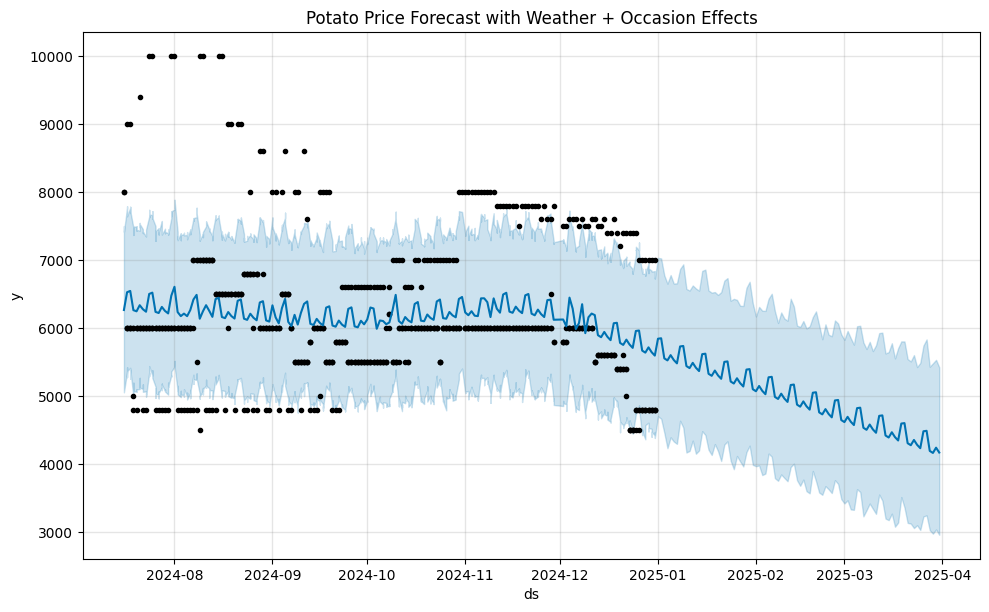

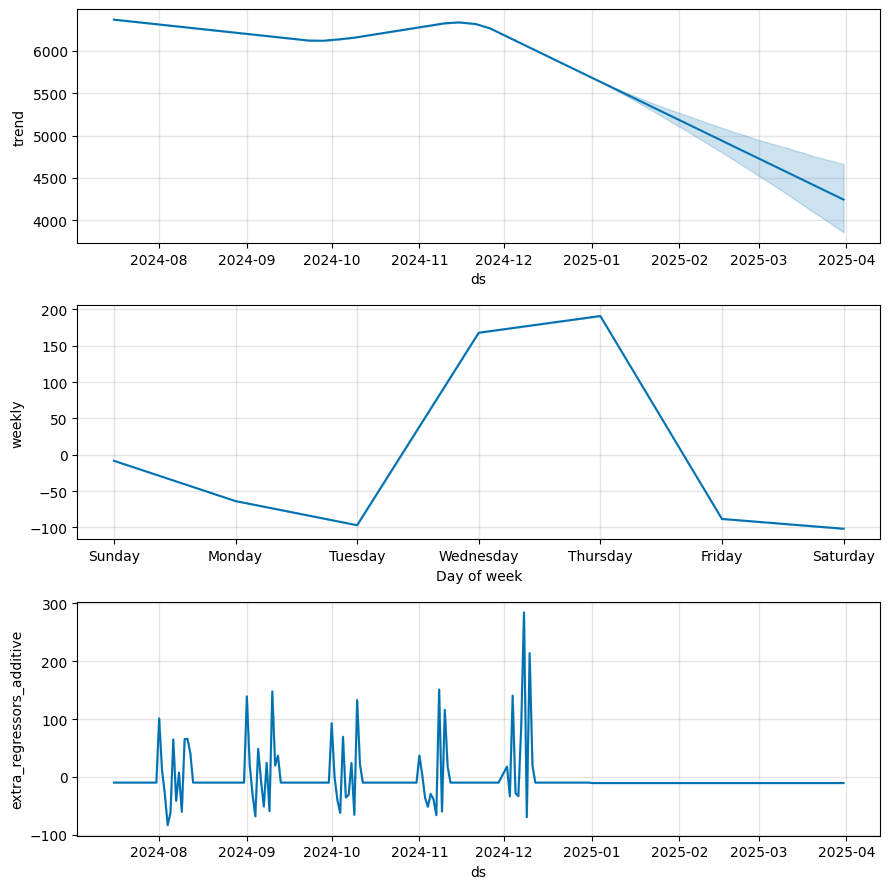

In [ ]:
# ===============================
# 7. Forecasting with Extra Features (Prophet)
# ===============================

# Prepare dataset
df_forecast = df_merged[['price_date',
                         'unnamed:_8', # Use correct price column
                         'tavg','prcp','impact_rating']].copy() # Remove 'tsun'

df_forecast = df_forecast.rename(columns={
    'price_date': 'ds',
    'unnamed:_8': 'y'
})

# Convert price to numeric
df_forecast['y'] = pd.to_numeric(df_forecast['y'], errors='coerce')

# Handle missing values
df_forecast['tavg'] = df_forecast['tavg'].fillna(df_forecast['tavg'].mean())
df_forecast['prcp'] = df_forecast['prcp'].fillna(0)   # assume no rain if missing

# Convert impact_rating text → numeric scale
impact_map = {"Low":1, "Medium":2, "High":3} # Simplified mapping based on cleaned data
df_forecast['impact_rating'] = df_forecast['impact_rating'].map(impact_map).fillna(0) # Use original 'impact_rating' column and map after filling NaNs

# Drop rows with missing price after converting to numeric
df_forecast = df_forecast.dropna(subset=['y'])


# Prophet model
model = Prophet()

# Add regressors (extra features)
model.add_regressor('tavg')
model.add_regressor('prcp')
model.add_regressor('impact_rating') # Use the correctly named and mapped column


# Fit model
model.fit(df_forecast)

# Create future dataframe
future = model.make_future_dataframe(periods=90)

# Add future values for regressors
# Use last known values (can replace with weather forecast API if available)
future = future.merge(df_forecast[['ds','tavg','prcp','impact_rating']].dropna(), on='ds', how='left') # Merge with non-null regressors from historical data


# Fill missing future values with reasonable defaults
future['tavg'] = future['tavg'].fillna(df_forecast['tavg'].mean())
future['prcp'] = future['prcp'].fillna(0)
future['impact_rating'] = future['impact_rating'].fillna(0)


# Forecast
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title("Potato Price Forecast with Weather + Occasion Effects")
plt.show()

# Plot components (trend, weekly, yearly, seasonality, regressors)
fig2 = model.plot_components(forecast)
plt.show()

In [ ]:
# Best dates to sell potatoes (top 5 forecasted prices)
best_dates = forecast.sort_values('yhat', ascending=False).head(5)[['ds','yhat']]
print("Best Selling Dates for Farmers:\n", best_dates)

Best Selling Dates for Farmers:
            ds         yhat
63 2024-08-01  6605.581341
62 2024-08-01  6605.581341
64 2024-08-01  6605.581341
65 2024-08-01  6605.581341
8  2024-07-18  6544.959528


In [ ]:
alerts = []

for _, row in forecast.iterrows():
    if row['prcp'] > df_forecast['prcp'].mean() and row['impact_rating'] >= 2:
        alerts.append((row['ds'], "⚠️ Risk of price drop due to high rainfall & festival demand impact."))
    elif row['impact_rating'] >= 2:
        alerts.append((row['ds'], "📈 Prices may rise during festival demand."))

print("\n🚨 Farmer Alerts:")
for date, msg in alerts[:10]:  # Show first 10 alerts
    print(date.date(), ":", msg)


🚨 Farmer Alerts:


In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 114.1 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

st.title("🌾 Farmer Potato Price Advisory Dashboard")

# Show best dates
st.subheader("📅 Best Selling Dates")
st.write(best_dates)

# Show risk alerts
st.subheader("⚠️ Risk Alerts")
for date, msg in alerts[:10]:
    st.write(f"{date.date()} → {msg}")


2025-11-07 07:42:21.361 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 07:42:21.364 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 07:42:21.367 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 07:42:21.370 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 07:42:21.372 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 07:42:21.373 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 07:42:21.387 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 07:42:21.388 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Prepare dataset
df = df_price.iloc[1:][['price_date','unnamed:_8']].rename(
    columns={'price_date':'ds','unnamed:_8':'y'}
)

# Convert 'y' to numeric and drop rows with non-numeric values
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df = df.dropna(subset=['y'])

df.set_index('ds', inplace=True)


# ======================
# 1. ARIMA Base Model
# ======================
arima = ARIMA(df['y'], order=(5,1,2))  # (p,d,q) - tune using AIC
arima_fit = arima.fit()

# Forecast with ARIMA
arima_forecast = arima_fit.get_forecast(steps=10)
arima_pred = arima_forecast.predicted_mean

# Residuals
df['residual'] = df['y'] - arima_fit.fittedvalues

# ======================
# 2. XGBoost on Residuals
# ======================
# Create lag features for residuals
lags = 7
df_ml = df.copy()
for lag in range(1, lags+1):
    df_ml[f'lag_{lag}'] = df_ml['residual'].shift(lag)

df_ml = df_ml.dropna()

X = df_ml[[f'lag_{i}' for i in range(1, lags+1)]]
y = df_ml['residual']

# Train XGBoost
xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5)
xgb.fit(X, y)

# Predict residual correction for next 10 days
last_row = df_ml.iloc[-1][[f'lag_{i}' for i in range(1, lags+1)]].values
residual_preds = []
for i in range(10):
    pred_res = xgb.predict([last_row])[0]
    residual_preds.append(pred_res)
    last_row = np.roll(last_row, 1)
    last_row[0] = pred_res

# ======================
# 3. Hybrid Forecast
# ======================
hybrid_forecast = arima_pred.values + np.array(residual_preds)

# Show results
future_dates = pd.date_range(start=df.index[-1]+pd.Timedelta(days=1), periods=10)
results = pd.DataFrame({"Date": future_dates,
                        "ARIMA_Forecast": arima_pred.values,
                        "Hybrid_Forecast": hybrid_forecast})

print(results)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsm

        Date  ARIMA_Forecast  Hybrid_Forecast
0 2024-08-30     6781.978587      6837.189406
1 2024-08-31     6719.996625      6974.630582
2 2024-09-01     6685.585126      6376.509870
3 2024-09-02     6653.563875      6671.390035
4 2024-09-03     6624.234405      6484.574432
5 2024-09-04     6596.152374      6602.291449
6 2024-09-05     6578.149650      6597.458844
7 2024-09-06     6562.183175      6490.655610
8 2024-09-07     6549.551520      6612.954844
9 2024-09-08     6539.434203      6671.862105


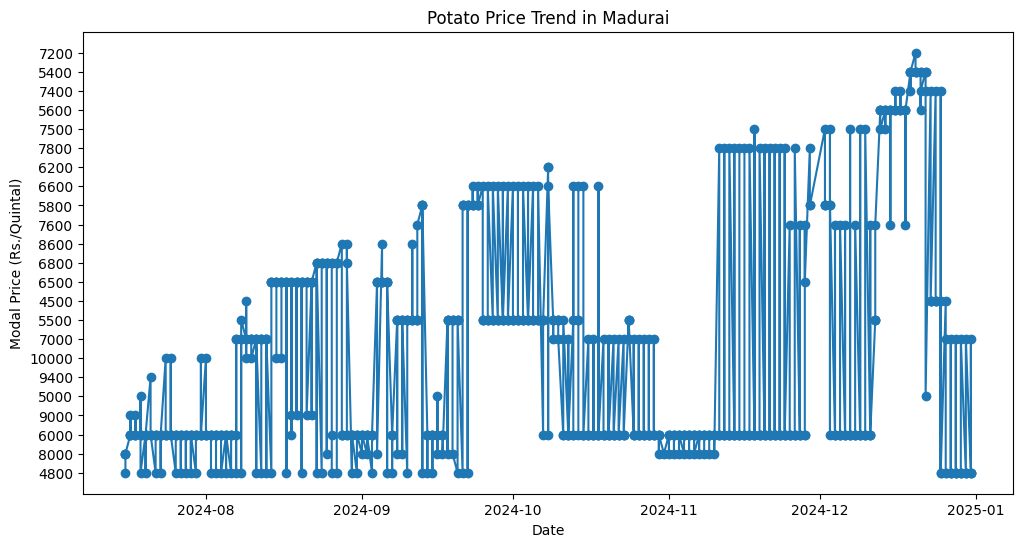

In [ ]:
df_price = df_price.sort_values(by='price_date')
madurai_df = df_price[df_price['unnamed:_1'].str.contains("Madurai", case=False, na=False)]
plt.figure(figsize=(12,6))
plt.plot(madurai_df['price_date'], madurai_df['unnamed:_8'], marker='o')
plt.title("Potato Price Trend in Madurai")
plt.xlabel("Date")
plt.ylabel("Modal Price (Rs./Quintal)")
plt.show()


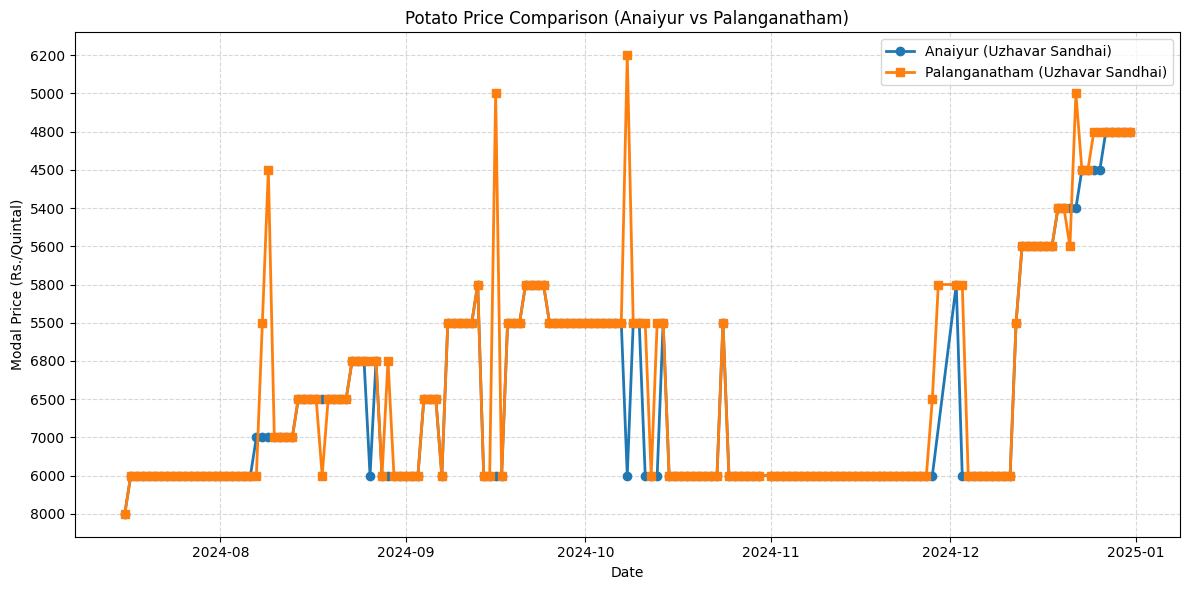

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(anaiyur['price_date'], anaiyur['unnamed:_8'],
         label="Anaiyur (Uzhavar Sandhai)", marker='o', linewidth=2)
plt.plot(palanganatham['price_date'], palanganatham['unnamed:_8'],
         label="Palanganatham (Uzhavar Sandhai)", marker='s', linewidth=2)

plt.title("Potato Price Comparison (Anaiyur vs Palanganatham)")
plt.xlabel("Date")
plt.ylabel("Modal Price (Rs./Quintal)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()